In [1]:
import gc
!nvidia-smi

Tue Aug  9 17:36:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 27%   37C    P8     4W / 120W |   1105MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist,cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
BIT_COUNT = 16
SALT_AND_PEPPER_AMOUNT = 0.01

In [4]:
def rgb2gray(rgb):
    if len(rgb.shape)==3:
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    else:
        r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]


    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

# 引入CIFAR10


In [5]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = rgb2gray(x_train)
x_train = np.expand_dims(x_train, axis=-1)
x_test = rgb2gray(x_test)
x_test = np.expand_dims(x_test, axis=-1)

x_train = x_train[:1500]

y_train = y_train[:1500]
x_test = x_test[:1500]

x_train = tf.image.resize(x_train, [28,28]).numpy()
x_test = tf.image.resize(x_test, [28,28]).numpy()

num_classes = 10
image_shape = (28, 28, 1)
x_train = x_train.reshape((-1,) + image_shape)
x_test = x_test.reshape((-1,) + image_shape)

# x_train =  np.concatenate((x_train[:,:14, :14, :] , x_train[:,:14, 14:, :] , x_train[:,14:, :14, :] , x_train[:,14:, 14:, :]))
# x_test =  np.concatenate((x_test[:,:14, :14, :] , x_test[:,:14, 14:, :] , x_test[:,14:, :14, :] , x_test[:,14:, 14:, :]))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# decoder網路

In [6]:
########
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.02, fill_mode = 'constant'),
    RandomZoom(.2, .2)
])
###########

In [7]:
adam = Adam(learning_rate=0.0002, beta_1=0.5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

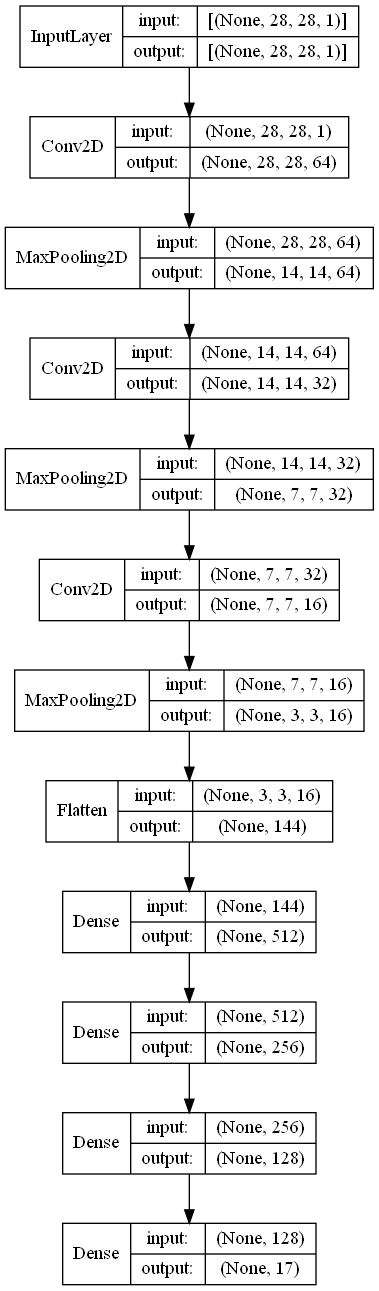

In [8]:
inputs = Input((28, 28, 1))
x = Conv2D(64, (3, 3), padding="same", activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(BIT_COUNT+1, activation="softmax")(x)
decoder = Model(inputs=inputs, outputs=x)
decoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy'])
decoder.summary()
from keras.utils.vis_utils import plot_model
plot_model(decoder, to_file='model.png', show_shapes=True,show_layer_names=False)

In [9]:
iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍


#loss_object = tf.keras.losses.BinaryCrossentropy()  #我們選擇的loss function


#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new, x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

In [10]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    dec_loss = losses["decoder"]

    plt.figure(figsize=(10, 8))
    plt.plot(dec_loss, label="decoder loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# salt&pepper

In [12]:
from skimage import io,util


def salt_and_pepper(img_orgin,amount):
    return  util.noise.random_noise(img_orgin.copy() ,mode ='s&p',amount = amount)

def batch_salt_and_pepper(img_batch, size):
    result_img = np.zeros_like(img_batch)
    for i in range(img_batch.shape[0]):
        result_img[i,:,:,0] = salt_and_pepper(img_batch[i,:,:,0],size)
    return result_img


In [13]:
x_train.shape

(1500, 28, 28, 1)

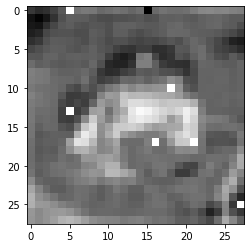

In [14]:
batch_test = batch_salt_and_pepper(x_train,SALT_AND_PEPPER_AMOUNT)
plt.imshow(batch_test[0,:,:,0],cmap='gray')

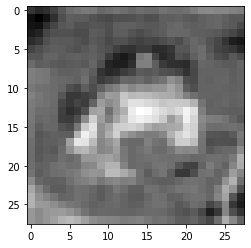

In [15]:
test_img = x_train[0,:,:,0]
plt.imshow(test_img,cmap='gray')

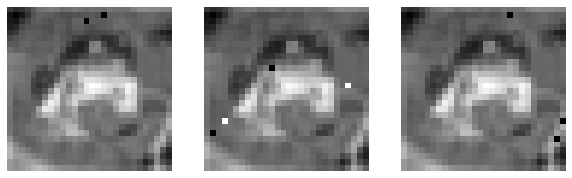

In [16]:

plt.figure(figsize=(10,10))
for idx,size in enumerate([0.001, 0.005, 0.01]):
    salt_and_pepper_result = salt_and_pepper(test_img,size)
    plt.subplot(1,3,idx+1)

    plt.imshow(salt_and_pepper_result,cmap='gray')
    #plt.imshow(np.log(cv2.magnitude(low_pass_f[:,:,0],low_pass_f[:,:,1])),cmap='gray')
    plt.axis('off')


plt.show()

In [17]:
EPOCH = 100
DATA_LENGTH = len(x_train)

# x_train_adv[0]是沒有攻擊的圖片
x_train_adv = [x_train.copy() for _ in range(BIT_COUNT+1)]

losses = {"decoder": []}

#開始訓練
for epoch in range(EPOCH):

    ##第一步 調整圖片 讓decoder能正確讀取出user_code
    for i in range(1, BIT_COUNT+1):
        x_train_adv[i] = pgd_attack_to_target(x_train_adv[i], [user_code[i]] * DATA_LENGTH,
                                              tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon,
                                              alpha, iterations)

    ##第二步 data augmentation(旋轉，縮放....)
  #  x_train_adv_att = [data_augmentation(x_train_adv[i]) for i in range(BIT_COUNT+1)]

    #做低通濾波
    x_train_adv_low_pass = [batch_salt_and_pepper(data_augmentation(x_train_adv[i]).numpy(),SALT_AND_PEPPER_AMOUNT) for i in range(BIT_COUNT+1)]


    #第四步 訓練Decoder
    decoder_x = np.concatenate((np.concatenate([batch_salt_and_pepper(x_train_adv[i],SALT_AND_PEPPER_AMOUNT) for i in range(BIT_COUNT+1)]),
                               # np.concatenate([x_train_adv_att[i] for i in range(BIT_COUNT+1)]),
                                np.concatenate([x_train_adv_low_pass[i] for i in range(BIT_COUNT+1)])))
    decoder_y = np.concatenate((np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)]),
                              #  np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)]),
                                np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)])))

    decoder_loss = decoder.fit(decoder_x, decoder_y, epochs=1)

    del decoder_x
    del decoder_y
   # del x_train_adv_att
    del x_train_adv_low_pass
    gc.collect()

    #紀錄loss
    # losses["discriminator"].append(discriminator_loss.history["loss"])
    losses["decoder"].append(decoder_loss.history["loss"])
    print("epoch:{}  decoder_loss:{}".format(epoch, decoder_loss.history["loss"]))



1594/1594 [==============================] - 5s 3ms/step - loss: 0.2296 - categorical_accuracy: 0.0576
epoch:0  decoder_loss:[0.2295522689819336]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2243 - categorical_accuracy: 0.0602
epoch:1  decoder_loss:[0.22434435784816742]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2242 - categorical_accuracy: 0.0594
epoch:2  decoder_loss:[0.2241986095905304]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2241 - categorical_accuracy: 0.0588
epoch:3  decoder_loss:[0.22413486242294312]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2241 - categorical_accuracy: 0.0584
epoch:4  decoder_loss:[0.22409120202064514]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2240 - categorical_accuracy: 0.0576
epoch:5  decoder_loss:[0.22404015064239502]
1594/1594 [==============================] - 4s 3ms/step - loss: 0.2240 - categorical_accuracy: 0.0606
epoch:6  decoder_

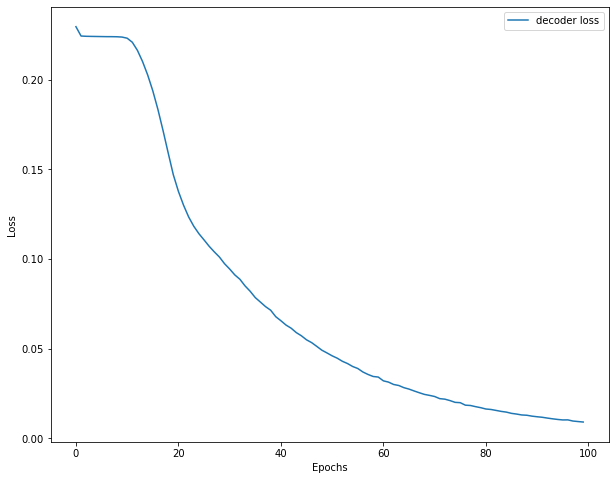

In [18]:
plot_loss(losses)

In [19]:
decoder.save('models/decoder_salt_and_pepper_cifar_adversarial_{}.h5'.format(SALT_AND_PEPPER_AMOUNT))

# TEST

In [20]:

del x_train_adv
del x_train
gc.collect()

2473

In [21]:
x_test_adv = [x_test.copy() for i in range(BIT_COUNT+1)]
for epoch in range(20):
    print("epoch:",epoch+1)
    for i in range(1, BIT_COUNT+1):

        x_test_adv[i] = pgd_attack_to_target(x_test_adv[i], [user_code[i]] * len(x_test),
                                             tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon, alpha,
                                             iterations)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20


In [22]:
test_acc_list = []

for i in range(BIT_COUNT+1):
    result = decoder.evaluate(x_test_adv[i], np.array([user_code[i]] * len(x_test)))
    test_acc_list.append(result[1])
print("accuracy:",np.mean(test_acc_list),"±",np.std(test_acc_list))

47/47 [==============================] - 0s 2ms/step - loss: 4.6046e-05 - categorical_accuracy: 1.0000
accuracy: 0.9978823486496421 ± 0.0078089511246272995


In [23]:
x_test_adv_att = [data_augmentation(x_test_adv[i]) for i in range(BIT_COUNT+1)]

In [24]:
test_att_acc_list = []
for i in range(BIT_COUNT+1):
    result = decoder.evaluate(x_test_adv_att[i], np.array([user_code[i]] * len(x_test)))
    test_att_acc_list.append(result[1])
print("accuracy:",np.mean(test_att_acc_list),"±",np.std(test_att_acc_list))

47/47 [==============================] - 0s 2ms/step - loss: 0.1758 - categorical_accuracy: 0.5140
accuracy: 0.5549803937182707 ± 0.11854391806799033


In [25]:
from skimage.metrics import peak_signal_noise_ratio
test_psnr_list = []
for i in range(1,BIT_COUNT+1):
    test_psnr_list.append(peak_signal_noise_ratio(x_test, x_test_adv[i]))
print("psnr:",np.mean(test_psnr_list),"±",np.std(test_psnr_list))

psnr: 41.327861432676 ± 0.24721219971443945
